# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 05**: Data pipeline with Neo4j

**Date**: October 5nd 2025

**Student Name**: Valeria Oliva Hdez

**Professor**: Pablo Camarillo Ramirez

# Dataset description

Este dataset contiene información de Spotify sobre los artistas que han realizado colaboraciones en canciones. 
Los artistas se representan como nodos y las colaboraciones son las aristas que conectan al cantante principal (source) con el secundario (target).

https://www.kaggle.com/datasets/jfreyberg/spotify-artist-feature-collaboration-network?select=nodes.csv

# Data ingestion

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on SparkSQL") \
    .master("spark://spark-master:7077") \
    .config("spark.jars.packages", "org.neo4j:neo4j-connector-apache-spark_2.13:5.3.10_for_spark_3") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.neo4j#neo4j-connector-apache-spark_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-64d3ea54-b84b-492d-9bd1-3d7a86ff2774;1.0
	confs: [default]
	found org.neo4j#neo4j-connector-apache-spark_2.13;5.3.10_for_spark_3 in central
	found org.neo4j#neo4j-connector-apache-spark_2.13_common;5.3.10_for_spark_3 in central
	found org.neo4j#caniuse-core;1.3.0 in central
	found org.neo4j#caniuse-api;1.3.0 in central
	found org.jetbrains.kotlin#kotlin-stdlib;2.1.20 in central
	found org.jetbrains#annotations;13.0 in central
	found org.neo4j#caniuse-neo4j-detection;1.3.0 in central
	found org.neo4j.driver#neo4j-java-driver-slim;4.4.21 in central
	found org.reactivestreams#reactive-streams;1.0.4 in central
	found io.netty#netty-handler;4.1.

In [2]:
# Build schema
# Import your module
from valeriaoliva.spark_utils import SparkUtils


edge_schema_columns = [
    ("id_0", "string"),
    ("id_1", "string"),
]
edge_schema = SparkUtils.generate_schema(edge_schema_columns)

base_path = "/opt/spark/work-dir/data/spotify"
df_edges = (spark.read
    .option("header", "true")
    .schema(edge_schema)
    .csv(f"{base_path}/edges.csv"))      

nodes_schema_columns = [
    ("spotify_id", "string"),          
    ("name", "string"),
    ("followers", "float"),              
    ("popularity", "int"),
    ("genres", "string"),           
    ("chart_hits", "string"),         
]
nodes_schema = SparkUtils.generate_schema(nodes_schema_columns)

df_nodes = (spark.read
    .option("header", "true")
    .schema(nodes_schema)
    .csv(f"{base_path}/nodes.csv")) 

df_edges.show(5)
df_nodes.show(5)


+--------------------+--------------------+
|                id_0|                id_1|
+--------------------+--------------------+
|76M2Ekj8bG8W7X2nb...|7sfl4Xt5KmfyDs2T3...|
|0hk4xVujcyOr6USD9...|7Do8se3ZoaVqUt3wo...|
|38jpuy3yt3QIxQ8Fn...|4csQIMQm6vI2A2SCV...|
|6PvcxssrQ0QaJVaBW...|6UCQYrcJ6wab6gnQ8...|
|2R1QrQqWuw3IjoP5d...|4mk1ScvOUkuQzzCZp...|
+--------------------+--------------------+
only showing top 5 rows


[Stage 1:>                                                          (0 + 1) / 1]

+--------------------+------------------+---------+----------+--------------------+--------------------+
|          spotify_id|              name|followers|popularity|              genres|          chart_hits|
+--------------------+------------------+---------+----------+--------------------+--------------------+
|48WvrUGoijadXXCsG...|         Byklubben|   1738.0|        24|['nordic house', ...|          ['no (3)']|
|4lDiJcOJ2GLCK6p9q...|          Kontra K|1999676.0|        72|['christlicher ra...|['at (44)', 'de (...|
|652XIvIBNGg3C0KIG...|             Maxim|  34596.0|        36|                  []|          ['de (1)']|
|3dXC1YPbnQPsfHPVk...|Christopher Martin| 249233.0|        52|['dancehall', 'lo...|['at (1)', 'de (1)']|
|74terC9ol9zMo8rfz...|     Jakob Hellman|  21193.0|        39|['classic swedish...|          ['se (6)']|
+--------------------+------------------+---------+----------+--------------------+--------------------+
only showing top 5 rows


# Transformations

In [3]:
# Add the code for your transformations to create nodes and edges DataFrames HERE
from pyspark.sql.functions import col

# --- NODES ---
artists_nodes = df_nodes.select(
    col("spotify_id").alias("id"),
    col("name"),
    col("followers"),
    col("popularity"),
    col("genres"),
    col("chart_hits")
).dropDuplicates(["id"])
artists_nodes.show()

# --- EDGES ---
feat_edges = (df_edges.select(
    col("id_0").alias("src"), 
    col("id_1").alias("dst"))
    .na.drop(subset=["src", "dst"])
    .filter(col("src") != col("dst"))
    .dropDuplicates(["src", "dst"]))
feat_edges.show()



+--------------------+--------------------+---------+----------+--------------------+--------------------+
|                  id|                name|followers|popularity|              genres|          chart_hits|
+--------------------+--------------------+---------+----------+--------------------+--------------------+
|000BblCiHJeKvtiq5...|           51 Koodia|   2170.0|        29|                  []|                NULL|
|000WMX8CCUlKyWxaO...|           John Wang|    391.0|         6|                  []|                NULL|
|001KkBGwhLqBrFXyh...|             Nyquest|   2185.0|        29|                  []|                NULL|
|001TzyVw5AcUSeuMj...|          Mc Belinha|      3.0|         0|                  []|                NULL|
|001oyhl94fb7YKL6f...|               Opiat|   1031.0|        55|                  []|                NULL|
|0028XGRl30uGds3H1...|           DJ Bordin|     51.0|         4|                  []|                NULL|
|002HSjuWsGMinkXTa...|               

[Stage 5:=============================>                             (1 + 1) / 2]

+--------------------+--------------------+
|                 src|                 dst|
+--------------------+--------------------+
|0hk4xVujcyOr6USD9...|7Do8se3ZoaVqUt3wo...|
|6PvcxssrQ0QaJVaBW...|6UCQYrcJ6wab6gnQ8...|
|2R1QrQqWuw3IjoP5d...|4mk1ScvOUkuQzzCZp...|
|1bAftSH8umNcGZ0uy...|1vqR17Iv8VFdzure1...|
|1mYsTxnqsietFxj1O...|7snhzmuew8iLEDxMI...|
|07iEy1AecUPVzfC2J...|6pFkB3HtAmNbNzeRM...|
|4I7D65YMlr6ZxVEGP...|5JqvosTRPE7gN9xSX...|
|0t6A5IoqSxQzxmMoD...|2Z9KL8Zmqx5Sg3cd7...|
|3tZdknQnzsVIIdaGC...|5ypEYwWaSgtjBPCPc...|
|4Y7tXHSEejGu1vQ9b...|5ncNJNBW6jRC3xnY7...|
|1dVbVQZjRGDjQmHD8...|4SwNIde9PXmYXhcBJ...|
|2hKfWlZLozDVOkReX...|6mKwmTMzDrye9elc8...|
|4BekCYjQpGl3aX7b6...|5U7pOnB9QgH7YFDWQ...|
|0b2GL7Y02vu50qieo...|7iJrDbKM5fEkGdm5k...|
|2RnDmyX1zzOkK5Cj9...|6sDJnRY60nGwPafQj...|
|5QdEbQJ3ylBnc3gsI...|5aIxroO72e4SZLbcO...|
|1yNOfXGQNGjAynk77...|44NX2ffIYHr6D4n7R...|
|1boMFBiRXiba4RCcP...|5cPFz5IHZH7LE8h2D...|
|3meJIgRw7YleJrmbp...|6lvaiTMh5DBQ4MJqq...|
|00roV7dDi7Y8kJHvc...|054D7n62qx

# Writing Data in Neo4j

In [6]:
# Add the code to write a graph from PySpark's DataFrames to Neo4j
neo4j_url = "bolt://neo4j-iteso:7687"
neo4j_user = "neo4j"
neo4j_passwd = "neo4j@1234"

artists_nodes.write \
  .format("org.neo4j.spark.DataSource") \
  .mode("Overwrite") \
  .option("url", neo4j_url) \
  .option("authentication.type", "basic") \
  .option("authentication.basic.username", neo4j_user) \
  .option("authentication.basic.password", neo4j_passwd) \
  .option("labels", ":Artist") \
  .option("node.keys", "id") \
  .save()
print(f"{artists_nodes.count()} artists wrote in Neo4j")

feat_edges.write \
  .format("org.neo4j.spark.DataSource") \
  .mode("Overwrite") \
  .option("url", neo4j_url) \
  .option("authentication.type", "basic") \
  .option("authentication.basic.username", neo4j_user) \
  .option("authentication.basic.password", neo4j_passwd) \
  .option("relationship", "FEATURED_WITH") \
  .option("relationship.save.strategy", "keys") \
  .option("relationship.source.labels", ":Artist") \
  .option("relationship.source.save.mode", "match") \
  .option("relationship.source.node.keys", "src:id") \
  .option("relationship.target.labels", ":Artist") \
  .option("relationship.target.save.mode", "match") \
  .option("relationship.target.node.keys", "dst:id") \
  .save()
print(f"{feat_edges.count()} feat edges wrote in Neo4j")


156320 artists wrote in Neo4j


[Stage 49:=============================>                            (1 + 1) / 2]

300386 feat edges wrote in Neo4j


# Read and Query Graphs with PySpark

In [10]:
# Add the code to read a data frame from Neo4J and run a simple query to verify 
cypher_df = spark.read \
    .format("org.neo4j.spark.DataSource") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("query",
            """
            MATCH (a:Artist)-[:FEATURED_WITH]->(b:Artist)
            RETURN a.name AS src, b.name AS dst
            """) \
    .load()

cypher_df.limit(10).show(truncate=False)

+----------+--------------+
|src       |dst           |
+----------+--------------+
|51 Koodia |Kotiteollisuus|
|John Wang |Joe L         |
|Nyquest   |Flyboiz       |
|Mc Belinha|Th CDM        |
|Opiat     |Białas        |
|Opiat     |Płomień 81    |
|Opiat     |Kabe          |
|Opiat     |Mr. Polska    |
|Opiat     |Pezet         |
|DJ Bordin |Mc Rd         |
+----------+--------------+



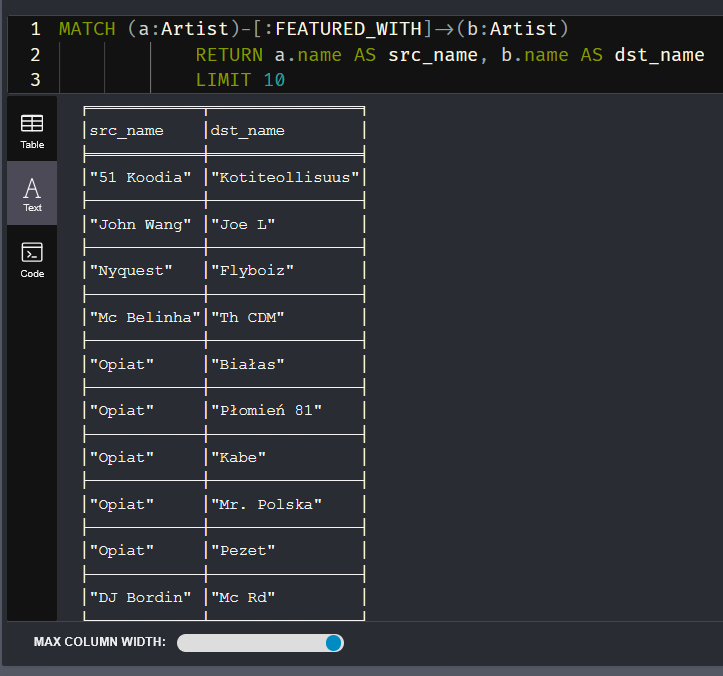

In [12]:
cypher_df = spark.read \
    .format("org.neo4j.spark.DataSource") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("query",
            """
            MATCH (a:Artist)-[:FEATURED_WITH]-()
            WITH a, count(*) AS collaborations
            RETURN a.name AS artist, collaborations
            ORDER BY collaborations DESC
            """) \
    .load()

cypher_df.limit(5).show(truncate=False)


+---------------------+--------------+
|artist               |collaborations|
+---------------------+--------------+
|Johann Sebastian Bach|1781          |
|Traditional          |1371          |
|Mc Gw                |858           |
|MC MN                |632           |
|Jean Sibelius        |580           |
+---------------------+--------------+



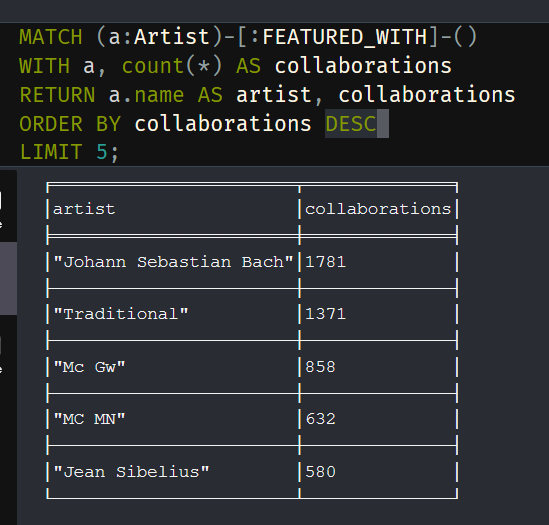

In [ ]:
sc.stop()